# Anticiper les besoins en consommation de bâtiments
## Modèle de prédiction de la consommation totale d'énergie des bâtiments

- Ce NoteBook est composé de :
    - A) Importation des données

    - B) Sélection de la target

    - C) Séparation du jeu de donnée

    - D) Sélection des features et features engineering
        1. Données physiques
            - Architecture des bâtiments
            - Superficie
        2. Année de construction
        3. Utilisation
            - One Hot Encoding
            - Target Encoding
            - Encoding Manuel
        4. Géographie
            - Encoding des quartiers
            - Encoding des clusters de quartiers
          
    - E) Etude des méthodes d'encoding pour la prédiction de la consommation énergétique avec la méthode de Random Forest

    - F) Etude des méthodes d'encoding pour la prédiction de la consommation énergétique avec la méthode de XGBoost

    - G) Etude des méthodes d'encoding pour la prédiction de la consommation énergétique avec la méthode de SVR

    - H) Etude des méthodes d'encoding pour la prédiction de la consommation surfacique avec la méthode de Random Forest
        
    - I) Conclusion sur le modèle de prédiction de la consommation énergétique des batiments 


### A) Importation des données

In [1]:
import branca.colormap as cm
from branca.colormap import LinearColormap
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn import linear_model
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
import time
import xgboost as xgb

In [3]:
data_extract = pd.read_csv('data_extract.csv')

### B) Sélection de la target

Les deux types de variables sélectionées pour la target de consommation d'énergie sont : 
- La consommation surfacique : 'SiteEUI(kBtu/sf)'; 
- La consommation totale : 'SiteEnergyUse(kBtu)'.

L'hypothèse selon laquelle la prise en compte de la météo avec la variable 'SiteEUIWN(kBtu/sf)' n'est pas pertinente dans ce cas est adopté, étant donné que l'analyse se limite à la ville de Seattle où les conditions météorologiques sont considérées comme constantes.

Concernant la consommation d'énergie totale du site, cela correspond à la quantité annuelle d'énergie consommée par la propriété provenant de toutes les sources d'énergie. La consommation totale énergétique possède les avantages suivants :
- Mesure de la consommation réelle : La consommation énergétique totale représente la quantité absolue d'énergie utilisée par un bâtiment. En étudiant cette mesure, on obtient une estimation précise de la consommation énergétique réelle, ce qui peut être important pour des analyses telles que la planification budgétaire ou la gestion de l'approvisionnement en énergie.
- Pertinence pour les objectifs de réduction : Lorsqu'il s'agit de réduire la consommation énergétique globale et les émissions de carbone, la consommation totale est une métrique clé. En analysant cette mesure, on peut identifier les bâtiments ou les secteurs qui ont le plus fort impact et concentrer les efforts de réduction sur eux.
- Comparaison entre les périodes ou les bâtiments : La consommation énergétique totale permet de comparer la performance énergétique entre différentes périodes de temps ou entre différents bâtiments sans normalisation. Cela peut être utile pour évaluer les progrès réalisés dans l'efficacité énergétique, identifier les écarts de consommation entre les bâtiments et déterminer les facteurs influençant la consommation globale.
- Base de calcul pour les coûts énergétiques : La consommation énergétique totale est souvent utilisée pour calculer les coûts énergétiques d'un bâtiment. En comprenant cette mesure, on peut évaluer les dépenses liées à l'énergie et prendre des décisions éclairées sur les mesures d'efficacité énergétique à mettre en œuvre.

Concernant la consommation surfacique du site, cela correspond à la consommation d'énergie du site d'un bien immobilier divisée par sa surface brute de plancher. La consommation d'énergie du site est la quantité annuelle de toute l'énergie consommée par le bien sur place, telle qu'elle apparaît sur les factures des services publics. L'IUE du site est mesuré en milliers d'unités thermiques britanniques (kBtu) par pied carré. Cette mesure présente les avantages suivants : 
 - Normalisation de la taille des bâtiments : En utilisant l'intensité énergétique en fonction de la surface, on tient compte de la taille des bâtiments. Cela permet de comparer l'efficacité énergétique entre des bâtiments de différentes tailles et d'identifier ceux qui sont plus performants en termes d'utilisation de l'énergie.
 - Comparabilité entre les bâtiments : En normalisant la consommation énergétique par la surface, on élimine en partie les variations dues à la taille des bâtiments. Cela permet de comparer plus équitablement la performance énergétique de différents bâtiments, qu'ils soient grands ou petits.
 - Identification des incohérences ou des anomalies : Lorsque l'on étudie l'intensité énergétique en fonction de la surface, on peut repérer plus facilement les bâtiments qui consomment de manière disproportionnée par rapport à leur taille. Cela peut aider à identifier des incohérences ou des anomalies potentielles dans les données de consommation énergétique.

 Dans un premier temps la consommation totale sera étudiée puisque c'est l'indicateur que l'on cherche à prédire puis la consommation surfacique sera étudiée pour comparer les performances du modèle. 

In [4]:
indic_conso = ['SiteEnergyUse(kBtu)']

In [5]:
indic_conso_intensite =['SiteEUI(kBtu/sf)']

### C) Séparation des jeux de données

Le jeu de données est divisé en ensembles : 
- d'entrainement : X_train, y_train ;
- de test : X_test, y_test. 

Une stratification est effectuée sur les valeurs extrêmes de la variable cible afin de limiter la variabilité du modèle. 

Il existe presque 50 usages principaux différents des bâtiments. Par conséquent ces usages sont regroupés dans des types d'usage. Regrouper les types d'utilisation des bâtiments en classes plus larges pour la prédiction présente les avantages suivants :
- Réduction de la complexité du modèle.
- Augmentation de la taille des échantillons.
- Amélioration de la généralisation du modèle.
- Réduction du déséquilibre de classe.

Les usages sont regroupés en fonction de deux aspects :
- Similitude des types d'utilisation du point de vue métier ; 
- Similitude de la consommation surfacique.

#### Regroupement des usages des bâtiments en type d'usages

In [6]:
def remove_missing_data(data, columns_to_check):
    """
    Supprime les lignes contenant des données manquantes dans un DataFrame.

    Args:
        data (pd.DataFrame): Le DataFrame à nettoyer.
        columns_to_check (list): Liste des noms de colonnes à vérifier pour les données manquantes.

    Returns:
        pd.DataFrame: Le DataFrame nettoyé.
    """
    cleaned_data = data.dropna(axis=0, how='any', subset=columns_to_check)
    return cleaned_data

In [7]:
data_extract = remove_missing_data(data_extract,['LargestPropertyUseType', 'SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)'])

In [8]:
# Praparation pour la visualisation des consommation surfaciques des usages pour le regroupement des types d'usage
conso_per_usage = data_extract.groupby(['LargestPropertyUseType']).agg({'SiteEUI(kBtu/sf)': 'mean'})
conso_per_usage.sort_values(by='SiteEUI(kBtu/sf)', ascending=False, inplace=True)

In [9]:
def general_barplot(data, x, y, xlabel, ylabel, title):
    """
    Crée un graphique à barres général.

    Args:
        data (pd.Series or pd.DataFrame): Les données à visualiser.
        x (str or pd.Series): Les valeurs pour l'axe x.
        y (str or pd.Series): Les valeurs pour l'axe y.
        xlabel (str): Étiquette de l'axe des x.
        ylabel (str): Étiquette de l'axe des y.
        title (str): Titre du graphique.

    Returns:
        None
    """
    plt.rcParams['font.size'] = 7

    sns.barplot(x=x, y=y, data=data)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    %config InlineBackend.figure_format = 'retina'
    %config InlineBackend.figure.dpi = 300

    plt.show()

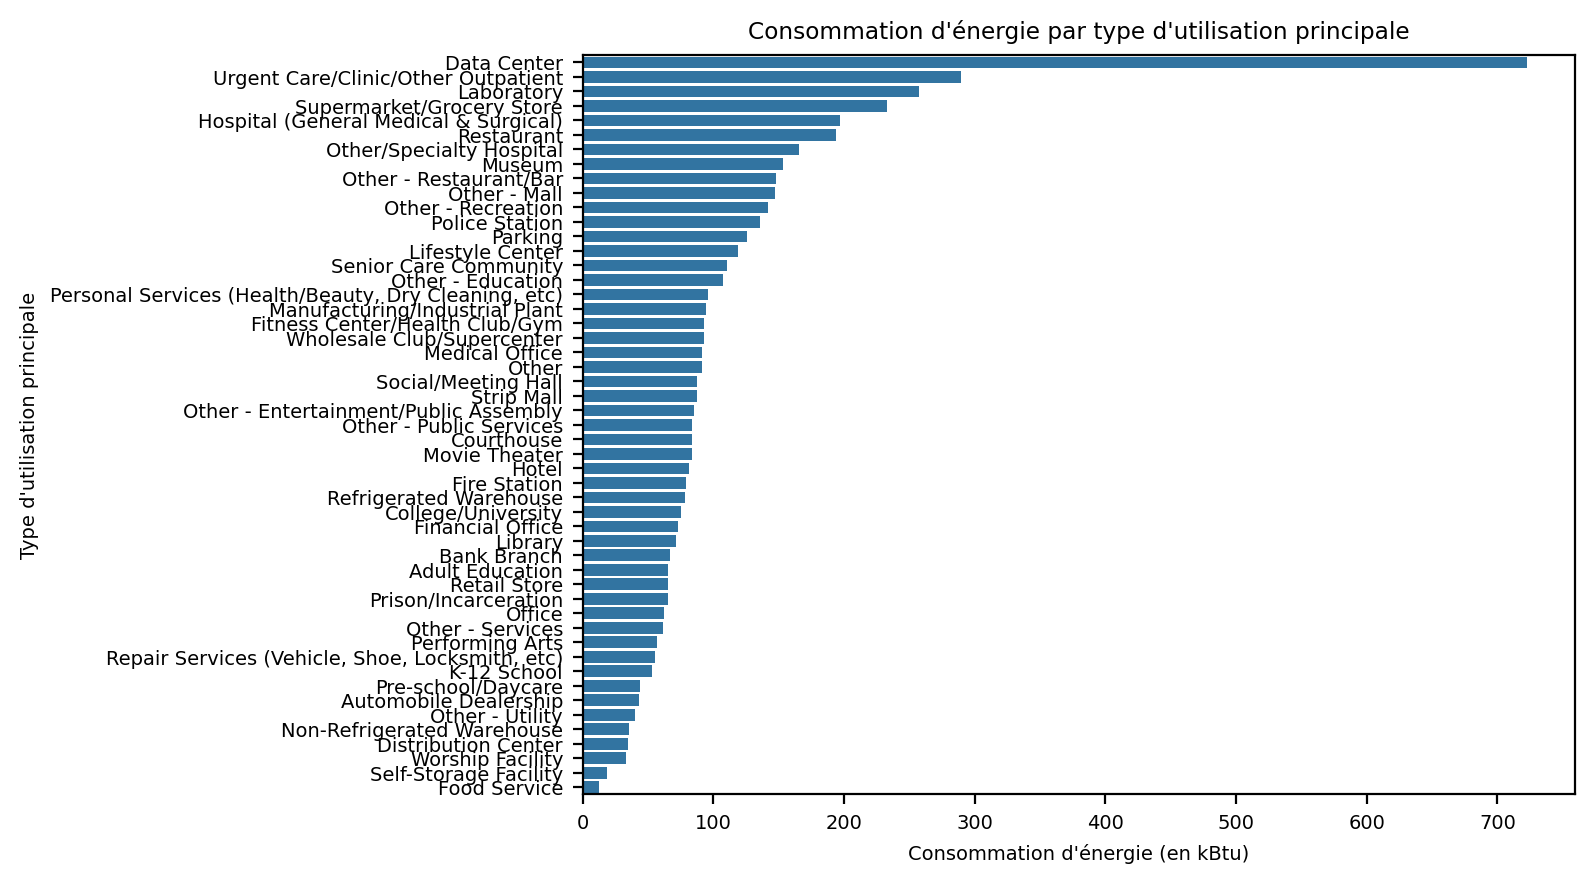

In [10]:
general_barplot(conso_per_usage, x=conso_per_usage['SiteEUI(kBtu/sf)'], y=conso_per_usage.index, xlabel="Consommation d'énergie (en kBtu)", ylabel="Type d'utilisation principale", title="Consommation d'énergie par type d'utilisation principale")

In [11]:
def apply_usage_correspondence(data, correspondance, usage_columns, finals_usages):
    """
    Applique une table de correspondance des usages à un DataFrame pour mapper les valeurs.

    Args:
        data (pd.DataFrame): Le DataFrame à traiter.
        correspondance (dict): Le dictionnaire de correspondance des usages.
        usage_columns (list): Liste des noms de colonnes d'usage à mapper.
        finals_usages (list): Liste des noms de colonnes d'usage après mapping.

    Returns:
        pd.DataFrame: Le DataFrame avec les colonnes d'usage mappées selon la correspondance.
    """
    for i, col in enumerate(usage_columns):
        data[finals_usages[i]] = data[col].map(correspondance)
    return data

In [12]:
def encode_target_mean_multiple(data_train, data_test, group_columns, target_column, new_column_names):
    """
    Encode plusieurs variables catégorielles en utilisant la moyenne de la variable cible par catégorie.

    :param data: Le DataFrame contenant les données.
    :param group_columns: Une liste des noms des colonnes catégorielles à encoder.
    :param target_column: Le nom de la colonne de la variable cible.
    :param new_column_names: Une liste des noms de nouvelles colonnes qui stockeront les moyennes encodées.

    :return: Le DataFrame avec les nouvelles colonnes encodées.
    """
    for i in range(len(group_columns)):
        # Calcul des moyennes de la variable cible par catégorie
        target_mean = data_train.groupby(group_columns[i])[target_column].mean()

        # Encodage de la variable catégorielle en utilisant les moyennes
        data_train[new_column_names[i]] = data_train[group_columns[i]].map(target_mean)
        data_test[new_column_names[i]] = data_test[group_columns[i]].map(target_mean)
        # Remplacement des valeurs manquantes par 0 (ou une autre valeur au choix)
        data_train[new_column_names[i]].fillna(0, inplace=True)
        data_test[new_column_names[i]].fillna(0, inplace=True)

    return data_train, data_test


In [13]:
# Dictionnaire de correspondance des usages et des types d'usage
correspondance_utilisation = {
    'Data Center': 'Data Center',
    'Urgent Care/Clinic/Other Outpatient': 'Médical',
    'Laboratory': 'Médical',
    'Hospital (General Medical & Surgical)': 'Médical',
    'Supermarket/Grocery Store': 'Magasin',
    'Restaurant': 'Restaurant',
    'Other/Specialty Hospital' : 'Médical',
    'Museum' : 'Divertissement', 
    'Other - Restaurant/Bar' : 'Restaurant',
    'Other - Recreation' : 'Divertissement',
    'Police Station' :'Service public',
    'Parking' :'Parking',
    'Lifestyle Center' :'Sport', 
    'Senior Care Community' :'Service',
    'Other - Education': 'Education',
    'Personal Services (Health/Beauty, Dry Cleaning...': 'Service à la personne',
    'Manufacturing/Industrial Plant': 'Usine industrielle',
    'Fitness Center/Health Club/Gym': 'Sport',
    'Wholesale Club/Supercenter': 'Magasin', 
    'Medical Office': 'Médical',
    'Other': 'Autres',
    'Social/Meeting Hall': 'Divertissement',
    'Strip Mall': 'Supermarché', 
    'Other - Entertainment/Public Assembly': 'Divertissement',
    'Other - Public Services': 'Service public',
    'Courthouse': 'Service public',
    'Movie Theater': 'Divertissement',
    'Hotel': 'Hotel', 
    'Fire Station': 'Service public',
    'Refrigerated Warehouse': 'Stockage',
    'College/University': 'Education',
    'Financial Office': 'Bureaux',
    'Library': 'Education',
    'Bank Branch': 'Service',
    'Adult Education': 'Education',
    'Retail Store' : 'Magasin', 
    'Prison/Incarceration': 'Service public',
    'Office': 'Bureaux',
    'Other - Services': 'Service',
    'Performing Arts': 'Divertissement',
    'Repair Services (Vehicle, Shoe, Locksmith, etc)': 'Service', 
    'K-12 School': 'Education', 
    'Pre-school/Daycare': 'Education',
    'Automobile Dealership': 'Autres', 
    'Other - Utility': 'Autres', 
    'Non-Refrigerated Warehouse': 'Stockage',
    'Distribution Center': 'Magasin',
    'Worship Facility': 'Lieu de culte', 
    'Self-Storage Facility': 'Stockage',
    'Other - Mall': 'Supermarché', 
    'Food Service': 'Restaurant',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'Service',
}

In [16]:
usage_columns = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
finals_usages = ['TypeUtilisationPrincipale', 'TypeUtilisationSecondaire', 'TypeUtilisationTertiaire']
data_extract = apply_usage_correspondence(data_extract, correspondance_utilisation, usage_columns, finals_usages)

In [17]:
data_extract['TypeUtilisationPrincipale'].value_counts()

TypeUtilisationPrincipale
Bureaux               487
Stockage              236
Magasin               187
Autres                 95
Hotel                  75
Médical                72
Divertissement         71
Lieu de culte          69
Education              66
Service                36
Parking                29
Restaurant             14
Supermarché            10
Service public          8
Sport                   7
Usine industrielle      7
Data Center             3
Name: count, dtype: int64

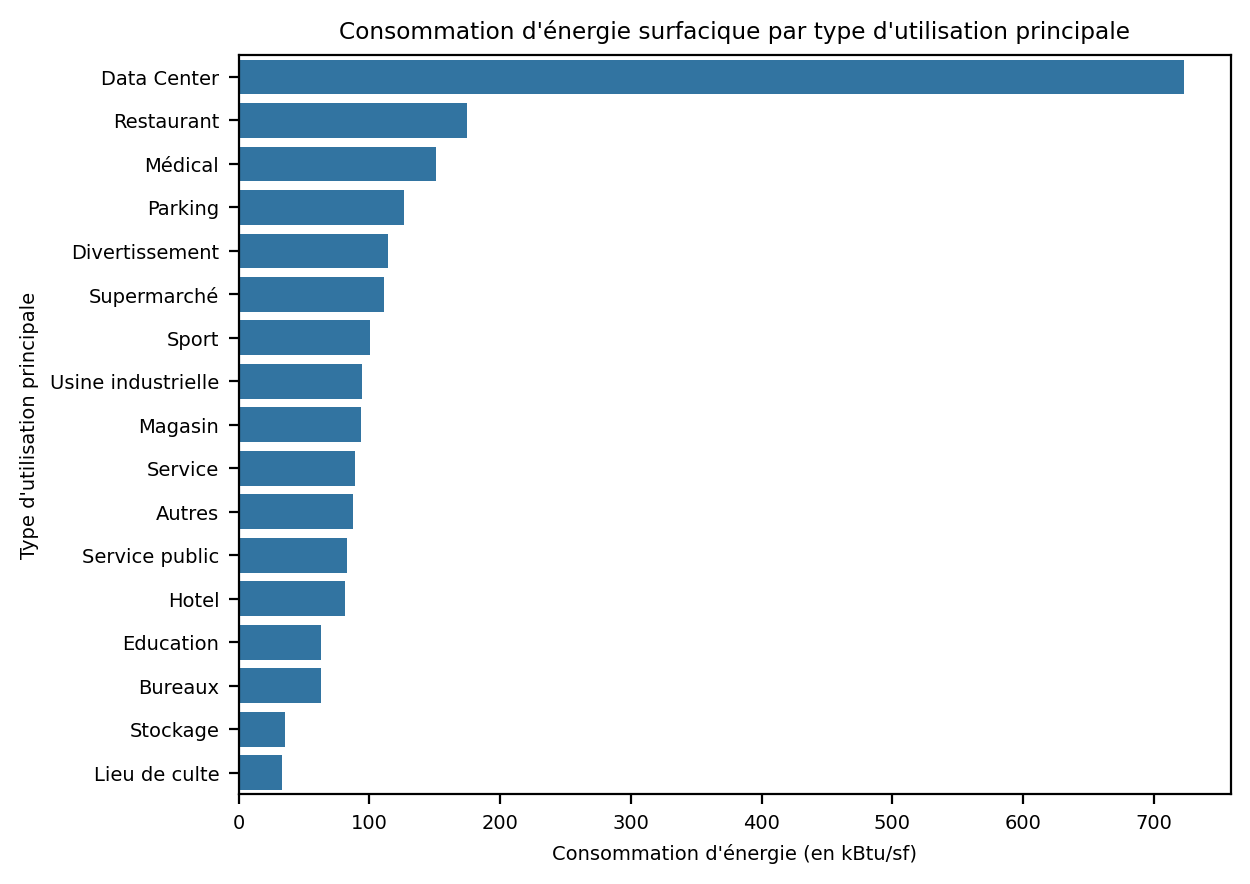

In [18]:
conso_per_usage = data_extract.groupby(['TypeUtilisationPrincipale']).agg({'SiteEUI(kBtu/sf)': 'mean'})
conso_per_usage.sort_values(by='SiteEUI(kBtu/sf)', ascending=False, inplace=True)
general_barplot(conso_per_usage, x=conso_per_usage['SiteEUI(kBtu/sf)'], y=conso_per_usage.index, xlabel="Consommation d'énergie (en kBtu/sf)", ylabel="Type d'utilisation principale", title="Consommation d'énergie surfacique par type d'utilisation principale")

Les consommations surfaciques des types d'usages regroupés sont cohérentes avec les consommations surfaciques par usage.

#### Séparation du jeu de données

Le jeu de donné est séparé en ensemble d'entrainement et de test.

In [19]:
def split_data(data_extract, indic_conso, indic_conso_intensite):
    """
    Prépare les données en séparant les features et la target, effectue la stratification et renvoie les ensembles d'entraînement et de test.

    Args:
        data_extract (pd.DataFrame): Le DataFrame contenant les données.
        indic_conso (list): Liste des indicateurs de consommation.
        indic_conso_intensite (list): Liste des indicateurs d'intensité de consommation.

    Returns:
        X_train (pd.DataFrame): Ensemble d'entraînement des features.
        X_test (pd.DataFrame): Ensemble de test des features.
        y_train (pd.DataFrame): Ensemble d'entraînement de la target.
        y_test (pd.DataFrame): Ensemble de test de la target.
    """
    # Crée une table de features en supprimant les colonnes d'indicateurs de consommation
    features = data_extract.drop(columns=indic_conso + indic_conso_intensite)
    
    # Crée une table de target en incluant uniquement les colonnes d'indicateurs de consommation
    target = data_extract[indic_conso + indic_conso_intensite]
    
    # Variables explicatives et cible
    X = features
    y = target
    
    # Convertit la colonne 'TypeUtilisationPrincipale' en chaîne de caractères
    features['TypeUtilisationPrincipale'] = features['TypeUtilisationPrincipale'].astype(str)
    
    # Stratification sur la variable catégorielle pour obtenir X_train et X_test
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=None, stratify=features['TypeUtilisationPrincipale']
    )
    
    print("Dimensions de l'ensemble d'entraînement :", X_train.shape, y_train.shape)
    print("Dimensions de l'ensemble de test :", X_test.shape, y_test.shape)
        
    return X_train, X_test, y_train, y_test

In [20]:
X_train, X_test, y_train, y_test = split_data(data_extract, indic_conso, indic_conso_intensite)

Dimensions de l'ensemble d'entraînement : (1177, 53) (1177, 2)
Dimensions de l'ensemble de test : (295, 53) (295, 2)


In [21]:
data_extract_train = pd.concat([X_train,y_train], axis=1)
data_extract_train.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Densite_etage,Age,Pourc_elec,Pourc_gas,Pourc_steam,TypeUtilisationPrincipale,TypeUtilisationSecondaire,TypeUtilisationTertiaire,SiteEnergyUse(kBtu),SiteEUI(kBtu/sf)
993,23743,2016,NonResidential,Mixed Use Property,Elliott Commons,1405 Elliott Ave W,Seattle,WA,98119.0,7666201770,...,0.5,92,0.693134,0.306866,0.0,Autres,Stockage,Bureaux,1.055033e+06,43.599998
109,238,2016,Nonresidential COS,Small- and Mid-Sized Office,North Service Center,1300 N 97th ST,Seattle,WA,98103.0,4310701070,...,1.0,66,0.748914,0.251086,0.0,Bureaux,Magasin,Parking,9.472358e+06,100.500000
1048,24132,2016,NonResidential,Refrigerated Warehouse,820 South Adams Building: 820 South Adams Street,820 South Adams Street,Seattle,WA,98108.0,7886101280,...,0.5,66,0.357181,0.642818,0.0,Stockage,NaN,NaN,1.610795e+06,63.900002
924,22866,2016,NonResidential,Small- and Mid-Sized Office,Fishermen's Commerce Building,4039 21st Ave W,Seattle,WA,98199.0,2771100895,...,2.0,40,1.000000,0.000000,0.0,Bureaux,NaN,NaN,1.286817e+06,53.599998
91,338,2016,NonResidential,Other,Jack R. McDonald Building,1900 9th Ave.,Seattle,WA,98101.0,0660001215,...,5.5,19,0.469132,0.530868,0.0,Autres,NaN,NaN,6.533698e+07,261.299988


#### D) Sélection des features et features engineering

Les catégories de features sont : 
- Données physique des bâtiments générale : 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)' 
- Type de batiment : 'BuildingType', 'PrimaryPropertyType'
- Données d'utilisation des bâtiments : 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'
- Age des batiments : 'YearBuilt'
- Données géographiques : 'Address', 'City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude'
- Energy star : 'YearsENERGYSTARCertified', 'ENERGYSTARScore'



Les catégories d'intérêts étudiées dans le modèle sont : 
- Les données physique des bâtiments : 
    - Superficie énergivore ;
    - Architecture des bâtiments (étages, nombre de bâtiments, etc.)
- L'âge des bâtiments : Age ; 
- Les données géographique ; 
- Les données d'utilisation ; 


La consommation énergétique totale des bâtiments semblent être corrélée à (voire analyse exploratoire): 
- Nombre de bâtiments ; 
- Nombre d'étage ; 
- Utilisation principale, secondaire et tertiaire (superficies) ; 
- Consommations d'énergies (intensité, autres sources, etc.)


##### 1/ Données physiques

L'objectif est d'étudier, de sélectionner et de transformer les données physiques d'intérêts.

Concernant les données physiques des bâtiments, les données peuvent être scindées en 2 catégories : 
- les données de superficie ; 
- les données d'architecture des bâtiments (nombre d'étages, nombre de bâtiments).

L'objectif est de sélectionner les variables de superficie pertinentes pour le modèle.

##### *Architecture*

Pour prendre en compte l'architecture du bâtiment 2 aspects sont à considérer : le nombre d'étage et le nombre de bâtiment. 
Pour cela, la densité d'étage par bâtiment est calculé (cf. Analyse exploratoire).

La densité d'étages par bâtiment peut avoir un impact sur la consommation énergétique. Par exemple, un bâtiment avec plusieurs étages et un seul bâtiment peut nécessiter une ventilation, un système de chauffage ou de refroidissement plus efficace pour desservir l'ensemble du bâtiment, ce qui peut influencer la consommation énergétique. Pour autant des bâtiments plus étalés peuvent induire à plus perte et une efficacité energétique plus faible. 

##### *Superficie*

Les variables sélectionnées pour les données de superficie sont 'PropertyGFABuilding(s)' et 'PropertyGFAParking' (cf. Analyse Exploratoire).

En somme les features correspondant aux caractéristiques physiques sélectionnées sont : 
- 'PropertyGFABuilding(s)'
- 'PropertyGFAParking'
- 'Densite_etage'

Les variables étudiées sont asymétriques (cf.Analyse exploratoire), par conséquent elles sont passées au log.

In [23]:
def process_physical_data(df_train, df_test):
    """
    Traite les données physiques en calculant et transformant les variables d'intérêt.

    Args:
        df_train (pd.DataFrame): Le DataFrame d'entrainement contenant les données physiques.
        df_test (pd.DataFrame): Le DataFrame de test contenant les données physiques.

    Returns:
        df_selected (pd.DataFrame): Le DataFrame d'entrainement avec les variables physiques transformées.
        df_selected_test (pd.DataFrame): Le DataFrame de test avec les variables physiques transformées.

    """
    # Copie explicite du DataFrame pour éviter les avertissements de SettingWithCopyWarning
    df_selected = df_train.copy()
    df_selected_test = df_test.copy()

    # Calcul de la variable 'Densite_etage' en prenant en compte la densité d'étage par bâtiment
    df_selected['Densite_etage'] = df_selected['NumberofFloors'] / (df_selected['NumberofBuildings'] + 1)
    df_selected_test['Densite_etage'] = df_selected_test['NumberofFloors'] / (df_selected_test['NumberofBuildings'] + 1)


    # Passage au log des données asymétriques
    columns_to_log = ['PropertyGFABuilding(s)', 'PropertyGFAParking', 'Densite_etage']
    for colonne in columns_to_log : 
        df_selected[colonne] = df_selected[colonne].apply(lambda x: np.log(x) if x != 0 else 0)
        df_selected_test[colonne] = df_selected_test[colonne].apply(lambda x: np.log(x) if x != 0 else 0)

    return df_selected, df_selected_test


In [24]:
data_extract_train, X_test = process_physical_data(data_extract_train, X_test)

##### 2/ Année de construction

La variable 'âge' des bâtiments est caclulée en prenant en compte la date de construction des bâtiments, 

In [25]:
def add_age_feature(df_train, df_test, year_column='YearBuilt'):
    """
    Ajoute la variable 'Age' aux données en soustrayant l'année de construction à l'année actuelle.

    Args:
        df_train (pd.DataFrame): Le DataFrame d'entrainement contenant les données.
        df_test (pd.DataFrame): Le DataFrame de test contenant les données.
        year_column (str): Le nom de la colonne contenant les années de construction.

    Returns:
        df_with_age (pd.DataFrame): Le DataFrame d'entrainement avec la variable 'Age' ajoutée.
        df_with_age_test (pd.DataFrame): Le DataFrame de test avec la variable 'Age' ajoutée.

    """
    current_year = 2023
    df_with_age = df_train.copy()
    df_with_age_test = df_test.copy()
    df_with_age['Age'] = current_year - df_train[year_column]
    df_with_age_test['Age'] = current_year - df_test[year_column]

    return df_with_age, df_with_age_test

In [27]:
data_extract_train, X_test = add_age_feature(data_extract_train, X_test)

Il n'y a pas d'asymétrie dans la distribution de l'âge des bâtiments.

##### 3/ Utilisation des bâtiments

Les données disponibles concernant l'utilisation des bâtiments comprennent le type d'utilisation et la superficie d'utilisation des trois premiers usages.

Le type d'usage est une variable catégorielle. Par conséquent cette variable nécessite un encodage scpécifique afin d'être intégrée au modèle. 

Les trois types d'encodage testés sont : 
- One Hot Encoding ; 
- Target Encoding ; 
- L'encodage "à la main" en utilisant les proportions de superficie pour les différents types d'utilisation.

Les différents encoding sont réalisés ci-dessous. 


##### *One Hot Encoding*

L'encodage "One Hot Code" est appliqué aux trois premiers types d'utilisation des bâtiments. Cela entraîne une augmentation du nombre de dimensions dans le jeu de données. Afin de réduire cette dimensionnalité et la complexité du modèle, deux méthodes sont étudiées :
- L'encodage des types d'utilisation regroupés plutôt que des utilisations spécifiques ; 
- L'ACP (Analyse en Composantes Principales).


**One Hot Encoding des utilisations spécifiques**

In [29]:
def one_hot_encode_columns(train_df, test_df, columns_to_encode):
    """
    Effectue l'encodage one-hot des colonnes spécifiées d'un DataFrame.

    Args:
        train_df (pd.DataFrame): Le DataFrame contenant les données d'entraînement.
        test_df (pd.DataFrame): Le DataFrame contenant les données de test.
        columns_to_encode (list): Liste des noms de colonnes à encoder en one-hot.

    Returns:
        encoded_train_df (pd.DataFrame): Le DataFrame d'entraînement avec les colonnes encodées en one-hot.
        encoded_test_df (pd.DataFrame): Le DataFrame de test avec les colonnes encodées en one-hot.
    """
    encoder = OneHotEncoder(sparse_output=False)

    # Encodage des colonnes pour les données d'entraînement

    data_to_encode_train = train_df[columns_to_encode].values
    encoded_data_train = encoder.fit_transform(data_to_encode_train)
    encoded_column_names_train = encoder.get_feature_names_out(columns_to_encode)
    encoded_train_df = pd.DataFrame(encoded_data_train, columns=encoded_column_names_train)
    encoded_train_df.reset_index(drop=True, inplace=True)
    train_df.reset_index(drop=True, inplace=True)
    train_df = train_df.join(encoded_train_df)
    
    # Encodage des colonnes pour les données de test

    data_to_encode_test = test_df[columns_to_encode].values
    encoded_data_test = encoder.fit_transform(data_to_encode_test)
    encoded_column_names_test = encoder.get_feature_names_out(columns_to_encode)
    encoded_test_df = pd.DataFrame(encoded_data_test, columns=encoded_column_names_test)
    encoded_test_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
    test_df = test_df.join(encoded_test_df)
    
    return train_df, test_df

In [30]:
data_extract_train, X_test = one_hot_encode_columns(data_extract_train, X_test, ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'])

In [31]:
# verification de l'encoding
data_extract_train['LargestPropertyUseType_Office'].value_counts() #OK

LargestPropertyUseType_Office
0.0    792
1.0    385
Name: count, dtype: int64

**One Hot Encoding des types d'utilisations**

In [32]:
# Baisse de dimension pour la catégorie principale
len(list(data_extract_train['LargestPropertyUseType'].unique())) - len(list(data_extract_train['TypeUtilisationPrincipale'].unique()))

32

In [33]:
# Baisse de dimension pour la catégorie secondaire
len(list(data_extract_train['SecondLargestPropertyUseType'].unique())) - len(list(data_extract_train['TypeUtilisationSecondaire'].unique()))

29

In [34]:
# Baisse de dimension pour la catégorie tertiaire
len(list(data_extract_train['ThirdLargestPropertyUseType'].unique())) - len(list(data_extract_train['TypeUtilisationTertiaire'].unique()))

20

En utilisant les types d'utilisation regroupés plutôt que les utilisations précises, nous avons réussi à réduire la dimensionalité de l'encodage one-hot de 66 catégories. Cette approche consiste à regrouper les utilisations similaires en catégories plus larges, ce qui permet de diminuer le nombre de variables créées lors de l'encodage one-hot. Cette réduction de la dimensionalité contribue à simplifier le modèle et peut améliorer son efficacité en réduisant la complexité et en évitant la surcharge de données.

In [35]:
data_extract_train, X_test = one_hot_encode_columns(data_extract_train, X_test, ['TypeUtilisationPrincipale', 'TypeUtilisationSecondaire', 'TypeUtilisationTertiaire'])

##### *Target encoding*

Pour effectuer le target encoding, la moyenne de la variable cible de consommation d'énergie est calculée pour chaque type d'utilisation. Cette moyenne est ensuite utilisée comme valeur encodée pour chaque observation correspondant à ce type d'utilisation. Le target encoding permet de capturer les informations de la variable cible dans l'encodage des variables explicatives, ce qui peut être utile pour améliorer les performances du modèle prédictif. En utilisant la moyenne de la variable cible pour chaque type d'utilisation, on exploite les informations agrégées sur les comportements de consommation d'énergie spécifiques à chaque catégorie.

In [37]:
def encode_target_mean_multiple(data_train, data_test, group_columns, target_column, new_column_names):
    """
    Encode plusieurs variables catégorielles en utilisant la moyenne de la variable cible par catégorie.

    :param data: Le DataFrame contenant les données.
    :param group_columns: Une liste des noms des colonnes catégorielles à encoder.
    :param target_column: Le nom de la colonne de la variable cible.
    :param new_column_names: Une liste des noms de nouvelles colonnes qui stockeront les moyennes encodées.

    :return: Le DataFrame avec les nouvelles colonnes encodées.
    """
    for i in range(len(group_columns)):
        # Calcul des moyennes de la variable cible par catégorie
        target_mean = data_train.groupby(group_columns[i])[target_column].mean()

        # Encodage de la variable catégorielle en utilisant les moyennes
        data_train[new_column_names[i]] = data_train[group_columns[i]].map(target_mean)
        data_test[new_column_names[i]] = data_test[group_columns[i]].map(target_mean)
        # Remplacement des valeurs manquantes par 0 (ou une autre valeur au choix)
        data_train[new_column_names[i]].fillna(0, inplace=True)
        data_test[new_column_names[i]].fillna(0, inplace=True)

    return data_train, data_test


In [38]:
liste_utilisation_target =['Categorie1_Encoded', 'Categorie2_Encoded', 'Categorie3_Encoded']

In [39]:
group_columns = ['TypeUtilisationPrincipale', 'TypeUtilisationSecondaire', 'TypeUtilisationTertiaire']

In [40]:
data_extract_train, X_test = encode_target_mean_multiple(data_extract_train,
                                                         X_test,
                                                         group_columns,
                                                         indic_conso[0],
                                                         liste_utilisation_target,
                                                         )

##### *Encodage manuel*


L'objectif est d'encoder les types d'utilisation en utilisant le pourcentage de la superficie associée à chaque type d'utilisation pour chaque bâtiment. 
Cela signifie que pour chaque bâtiment, la proportion de la superficie totale attribuée à chaque type d'utilisation est calculée. Ensuite, ces proportions sont utilisées comme valeurs encodées pour chaque observation, indiquant la contribution relative de chaque type d'utilisation à la superficie totale du bâtiment. Cet encodage basé sur les pourcentages permet de tenir compte de la répartition des différents types d'utilisation dans chaque bâtiment, ce qui peut être pertinent pour la prédiction des consommations d'énergie.

In [42]:
def encode_and_transform_surfaces(data_train, data_test, index_columns, group_columns, target_column):
    """
    Encode les variables catégorielles et transforme les surfaces en proportion de la superficie totale.

    :param data_train: Le DataFrame d'entraînement contenant les données.
    :param data_test: Le DataFrame de test contenant les données.
    :param index_columns: Une liste des noms de colonnes servant d'index.
    :param group_columns: Une liste des noms de colonnes catégorielles à encoder.
    :param target_column: Le nom de la colonne de la variable cible.

    :return: Les DataFrames d'entraînement et de test mis à jour.
    """

    # Création des DataFrames contenant les surfaces par catégorie
    new_df1 = pd.pivot_table(data_train, index=index_columns, values='LargestPropertyUseTypeGFA', columns=group_columns[0], aggfunc='sum', fill_value=0)
    new_df2 = pd.pivot_table(data_train, index=index_columns, values='SecondLargestPropertyUseTypeGFA', columns=group_columns[1], aggfunc='sum', fill_value=0)
    new_df3 = pd.pivot_table(data_train, index=index_columns, values='ThirdLargestPropertyUseTypeGFA', columns=group_columns[2], aggfunc='sum', fill_value=0)
    
    liste_usage = list(new_df1.keys().unique())

    # Fusion des DataFrames
    merged_df = new_df1.add(new_df2, fill_value=0).add(new_df3, fill_value=0)
    merged_df.reset_index(inplace=True)

    # Fusion des DataFrames d'entraînement et de test avec les nouvelles colonnes
    data_train = data_train.merge(merged_df, on='OSEBuildingID', how='left')
    data_test = data_test.merge(merged_df, on='OSEBuildingID', how='left')

    # Calcul de l'inverse du logarithme des colonnes PropertyGFAParking et PropertyGFABuilding(s)
    inverse_log_parking = np.exp(data_train['PropertyGFAParking'])
    inverse_log_building = np.exp(data_train['PropertyGFABuilding(s)'])

    # Calcul de la somme des inverses du logarithme des deux colonnes
    sum_inverse_logs = inverse_log_parking + inverse_log_building

    # Transformation des surfaces en proportion de la superficie totale
    for col in merged_df.columns:
        data_train[col] = data_train[col] / sum_inverse_logs

    # Calcul de l'inverse du logarithme pour le DataFrame de test
    inverse_log_parking_test = np.exp(data_test['PropertyGFAParking'])
    inverse_log_building_test = np.exp(data_test['PropertyGFABuilding(s)'])

    sum_inverse_logs_test = inverse_log_parking_test + inverse_log_building_test

    # Transformation des surfaces en proportion de la superficie totale pour le DataFrame de test
    for col in merged_df.columns:
        data_test[col] = data_test[col] / sum_inverse_logs_test


    return data_train, data_test

In [43]:
liste_index = ['OSEBuildingID']
target_columns = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']

In [44]:
data_extract_train, X_test = encode_and_transform_surfaces(data_extract_train,
                                                           X_test,
                                                           'OSEBuildingID',
                                                           group_columns, 
                                                           target_columns,
                                                           )

##### 5/ Données géographiques

L'intégration des données géographiques dans le modèle se fait en deux étapes : l'utilisation des quartiers ou la création de nouveaux clusters, suivie de l'encodage "one-hot" ou de l'encodage basé sur la valeur cible. Cela permet de capturer les informations géographiques.

En résumé, les données géographiques sont utilisées pour créer des regroupements pertinents, puis ces regroupements sont encodés soit avec l'approche "one-hot" soit avec l'encodage basé sur la valeur cible. 

In [45]:
def preprocess_neighborhood_data(data_extract_train, X_test):
    """
    Met en majuscule les données de quartiers pour les homogénéiser et corrige une erreur de saisie.

    Args:
    data_extract_train (pandas.DataFrame): Le DataFrame d'extraction d'entraînement avec la colonne 'Neighborhood'.
    X_test (pandas.DataFrame): Le DataFrame des données de test avec la colonne 'Neighborhood'.

    Returns:
    None
    """

    # Mettre en majuscule les données de quartiers pour homogénéiser
    data_extract_train['Neighborhood'] = data_extract_train['Neighborhood'].str.capitalize()
    X_test['Neighborhood'] = X_test['Neighborhood'].str.capitalize()

    # Correction d'une erreur de saisie des quartiers
    data_extract_train.loc[data_extract_train['Neighborhood'] == 'Delridge neighborhoods', 'Neighborhood'] = 'Delridge'
    X_test.loc[X_test['Neighborhood'] == 'Delridge neighborhoods', 'Neighborhood'] = 'Delridge'

    return data_extract_train, X_test


In [46]:
data_extract_train, X_test = preprocess_neighborhood_data(data_extract_train, X_test)

##### *Encoding en fonction des quartiers*

Pour les quartiers déjà présents dans le jeu de données, deux méthodes d'encodage différentes sont utilisées :
- le target encoding basée sur la moyenne de consommations énergétique ; 
- le one hot encoding. 

##### **Target encoding des quartiers**

In [47]:
data_extract_train, X_test = encode_target_mean_multiple(data_extract_train, X_test, ['Neighborhood'], indic_conso[0], ['Neighborhood_Encoded'])

##### **One hot encoding des quartiers**

In [48]:
data_extract_train, X_test = one_hot_encode_columns(data_extract_train, X_test, ['Neighborhood'])

##### *Encoding en fonction des clusters*

Dans le processus de création des clusters, deux méthodes différentes sont explorées :
- Clustering par K-Means : Cette méthode consiste à regrouper les données en clusters en utilisant l'algorithme K-Means. Les clusters sont déterminés en fonction de la similarité des caractéristiques des données de latitude et longitude. 
- Clustering par DBScan : Cette méthode utilise l'algorithme DBScan (Density-Based Spatial Clustering of Applications with Noise) pour regrouper les données en fonction de leur densité. Les points de données qui sont suffisamment proches les uns des autres sont regroupés dans un même cluster, tandis que les points isolés sont considérés comme du bruit. 

Une fois les clusters créés, l'encodage des clusters peut être réalisé en utilisant le one-hot encoding, où chaque cluster est représenté par des variables binaires distinctes, ou en utilisant le target encoding, où chaque cluster est associé à une valeur cible basée sur les données de consommation énergétique.

##### **Clustering par K-Means et encodage**

`Clustering K-Means :`

In [49]:
def assign_neighborhood_clusters(data_extract_train, X_test, num_clusters=20, num_runs=1):
    """
    Affecte des clusters aux quartiers basés sur leurs coordonnées longitudinales et latitudinales.

    Args:
    data_extract_train (pandas.DataFrame): DataFrame d'extraction d'entraînement contenant les coordonnées des quartiers.
    X_test (pandas.DataFrame): DataFrame des données de test avec les coordonnées des quartiers.
    num_clusters (int): Nombre de clusters (par défaut : 20).
    num_runs (int): Nombre d'exécutions de l'algorithme pour chaque nombre de clusters (par défaut : 1).

    Returns:
    pandas.DataFrame: Les DataFrames modifiés avec les clusters attribués.
    """

    # Création du modèle KMeans
    model = KMeans(n_clusters=num_clusters)
    labels = model.fit_predict(data_extract_train[['Longitude', 'Latitude']])

    # Méthode du coude pour identifier le nombre de clusters
    wcss_mean = []
    wcss = []
    for k in range(1, 50):
        for _ in range(num_runs):
            kmeans = KMeans(n_clusters=k, n_init=10)
            kmeans.fit(data_extract_train[['Longitude', 'Latitude']])
            wcss.append(kmeans.inertia_)
        wcss_mean.append(np.mean(wcss))

    plt.plot(range(1, 50), wcss_mean)
    plt.ylabel('Distances intra-cluster (WCSS)')
    plt.xlabel('Nombre de clusters')
    plt.show()

    # Attribution des clusters à la base de données d'entraînement
    labels = pd.DataFrame(labels)
    data_extract_train.reset_index(drop=True, inplace=True)
    labels.reset_index(drop=True, inplace=True)
    data_extract_train = pd.concat([data_extract_train, labels], axis=1)
    data_extract_train.rename(columns={0: 'Cluster_quartiers'}, inplace=True)

    # Attribution des clusters aux données de X_test
    X_test['Cluster_quartiers'] = model.predict(X_test[['Longitude', 'Latitude']])

    return data_extract_train, X_test


Un nombre de clusters de 20 est choisi. 

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


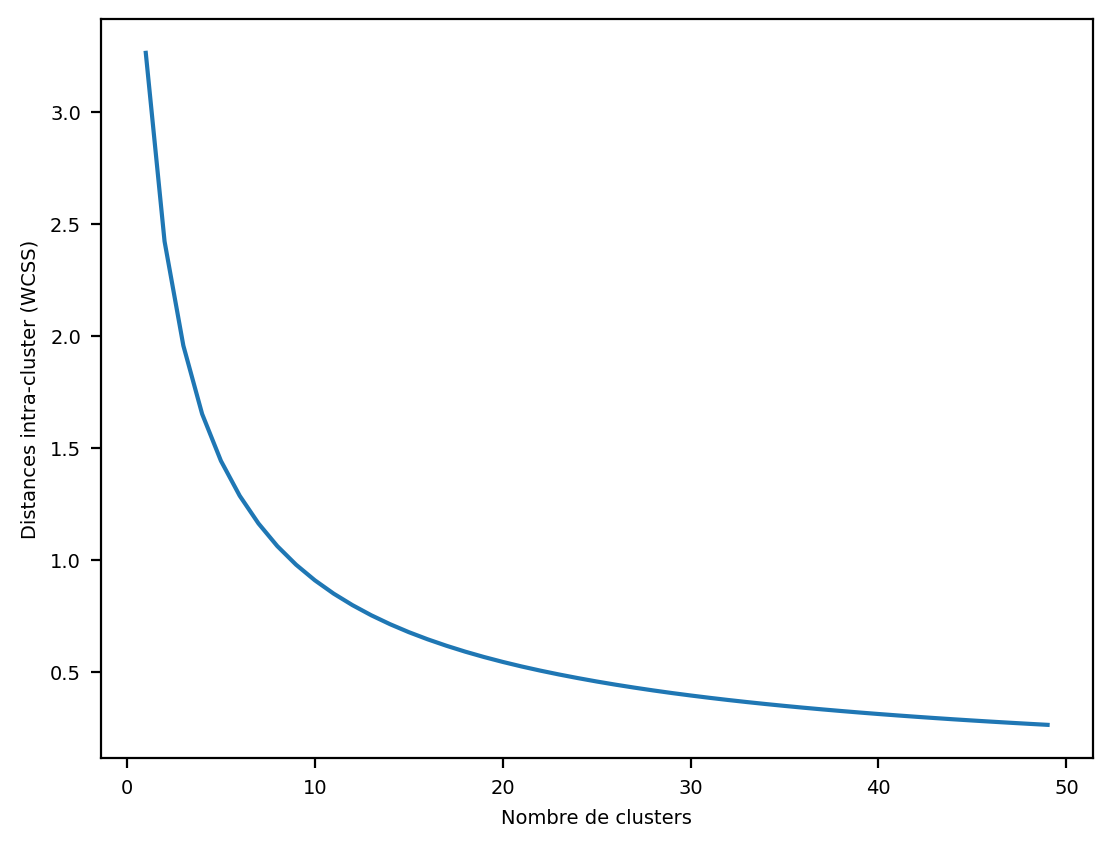

In [50]:
data_extract_train, X_test = assign_neighborhood_clusters(data_extract_train, X_test, num_clusters=20, num_runs=1)

In [51]:
def create_map(data, lat_col, lon_col, cluster_col, couleurs):
    """"
    Crée une carte interactive représentant les clusters géographiques.

    Args:
    data (DataFrame): Les données à cartographier.
    lat_col (str): Nom de la colonne contenant les données de latitude.
    lon_col (str): Nom de la colonne contenant les données de longitude.
    cluster_col (str): Nom de la colonne contenant les clusters.
    couleurs (list): Liste des couleurs utilisée pour les clusters.

    Returns:
    folium.Map: Objet carte Folium représentant les clusters géographiques.
    """
    # Création de la base pour la cartographie des clusters
    data_extract_carto = data[[lat_col, lon_col, cluster_col]].dropna(axis=0, how='any')

    # Liste des couleurs

    # Création de la carte
    map = folium.Map(location=[data_extract_carto[lat_col].iloc[0], data_extract_carto[lon_col].iloc[0]], zoom_start=12)

    # Obtenir les clusters uniques
    quartiers = data_extract_carto[cluster_col].unique()

    # Parcours des données pour ajouter les marqueurs à la carte
    for _, row in data_extract_carto.iterrows():
        lat = row[lat_col]
        lon = row[lon_col]
        tooltip = row[cluster_col]
        color = couleurs[list(quartiers).index(row[cluster_col])]
        marker = folium.CircleMarker([lat, lon], tooltip=tooltip, fill=True, color=color, fill_opacity=0.7, radius=4)
        marker.add_to(map)

    # Création de la légende
    legend_html = '<div style="position:fixed; bottom:50px; right:50px; z-index:100; background:white; padding:10px; border:1px solid grey;">'
    for quartier, couleur in zip(quartiers, couleurs):
        legend_html += f'<div style="margin-bottom:5px;"><span style="background:{couleur}; width:12px; height:12px; display:inline-block; margin-right:5px;"></span>{quartier}</div>'
    legend_html += '</div>'

    map.get_root().html.add_child(folium.Element(legend_html))
    
    return map


In [52]:
couleurs = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'turquoise', 'brown',
                'gray', 'black', 'white', 'gold', 'silver', 'magenta', 'cyan', 'lime', 'teal', 'navy', 'maroon']

# Utilisation de la fonction
create_map(data_extract_train, 'Latitude', 'Longitude', 'Cluster_quartiers', couleurs)

20 clusters sont crées pour la ville de Seattle. Par conséquent le maillage est plus fin que pour les quartiers déjà présents dans la base de données (17 quartiers).

`Target encoding des clusters K-Means :`

In [53]:
data_extract_train, X_test = encode_target_mean_multiple(data_extract_train,
                                                         X_test,
                                                         ['Cluster_quartiers'],
                                                         indic_conso[0],
                                                         ['Cluster_quartiers_Encoded'],
                                                         )

`One hot encoding des clusters K-Means :`

In [54]:
data_extract_train, X_test = one_hot_encode_columns(data_extract_train, X_test, ['Cluster_quartiers'])

##### **Clustering par K-DBScan et encodage**

In [55]:
def apply_dbscan(data, lat_lon_columns, eps=0.2, min_samples=5):
    """
    Applique l'algorithme DBSCAN pour regrouper les données géographiques en clusters.

    Args:
    data (DataFrame): Les données à traiter.
    lat_lon_columns (list): Liste des noms des colonnes Latitude et Longitude.
    eps (float, optional): Le paramètre epsilon pour DBSCAN (défaut : 0.2).
    min_samples (int, optional): Le nombre minimal d'échantillons pour un cluster (défaut : 5).

    Returns:
    DataFrame: Les données initiales avec la colonne des clusters DBSCAN.
    """
    # Suppression des valeurs manquantes dans Latitude et Longitude
    data_extract_dbscan = data.dropna(axis=0, how='any', subset=lat_lon_columns)

    # Normalisation des données de Latitude et Longitude
    scaler = StandardScaler()
    data_extract_dbscan_normalized = scaler.fit_transform(data_extract_dbscan[lat_lon_columns])

    # Application de l'algorithme DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data_extract_dbscan_normalized)
    labels = pd.DataFrame(labels)

    data_extract_dbscan.reset_index(drop=True, inplace=True)
    labels.reset_index(drop=True, inplace=True)

    # Ajout des labels de clusters DBSCAN aux données d'origine
    data_extract_dbscan = pd.concat([data_extract_dbscan, labels], axis=1)
    data_extract_dbscan.rename(columns={0: 'Cluster_quartiers_DBSCAN'}, inplace=True)

    return data_extract_dbscan

In [56]:
# Utilisation de la fonction
data_extract_dbscan = apply_dbscan(data_extract_train, ['Longitude', 'Latitude'], eps=0.2, min_samples=5)

In [57]:
couleurs = [
    "red",
    "green",
    "blue",
    "yellow",
    "orange",
    "purple",
    "pink",
    "brown",
    "gray",
    "black",
    "white",
    "cyan",
    "magenta",
    "lightblue",
    "lightgreen",
    "lightpink",
    "lightgray",
    "darkred",
    "darkgreen",
    "darkblue",
    "darkyellow",
    "darkpurple",
    "gold",
    "silver",
]

# Utilisation de la fonction
create_map(data_extract_dbscan, 'Latitude', 'Longitude', 'Cluster_quartiers_DBSCAN', couleurs)

In [58]:
data_extract_dbscan['Cluster_quartiers_DBSCAN'].value_counts()

Cluster_quartiers_DBSCAN
 2     749
-1     115
 0     109
 5      44
 4      22
 3      19
 11     16
 13     14
 10     14
 7      13
 8      12
 1       8
 14      8
 6       7
 9       6
 12      6
 16      5
 15      5
 17      5
Name: count, dtype: int64

Il semble y avoir des bâtiments dans les données qui sont attribués à un cluster DBScan avec une valeur de -1, ce qui signifie qu'ils sont considérés comme du bruit ou des valeurs aberrantes.

La méthode DBScan utilisée pour effectuer le clustering des données géographiques n'a pas donné les résultats escomptés (trop de valeurs associé à un cluster de '-1'), et par conséquent, elle a été abandonnée.

### E) Etude des méthodes d'encoding pour la prédiction de la consommation énergétique avec la méthode de random forest

L'objectif de cette étude est d'explorer différentes méthodes d'encodage pour les données d'utilisation des bâtiments et les données géographiques. 
Il y a 3 méthodes d'encodage des données d'utilisation des bâtiments et 4 méthodes concernant les données géogrpahiques, soit 12 scénarios à explorer.

Pour cela, le premier modèle utilisé est une forêt aléatoire (random forest), en raison de ses avantages suivants :
- Performances élevées : La forêt aléatoire est connue pour fournir de bonnes performances de prédiction.
Robustesse aux valeurs aberrantes : Ce modèle est relativement robuste face aux valeurs aberrantes, ce qui est important compte tenu de la présence potentielle de telles valeurs dans les données.
- Gestion automatique des variables : La forêt aléatoire est capable de sélectionner automatiquement les variables pertinentes pour la prédiction, simplifiant ainsi le processus de modélisation.
- Capacité à capturer les interactions non linéaires : Ce modèle est capable de capturer les relations non linéaires entre les variables, ce qui peut être important pour modéliser la consommation énergétique.
- Estimation de l'importance des variables : La forêt aléatoire fournit une estimation de l'importance des variables, ce qui permet de déterminer les facteurs les plus influents dans les prédictions.
-Robustesse face à l'overfitting : La forêt aléatoire a tendance à être moins sujette au surajustement (overfitting) par rapport à d'autres modèles plus complexes.

La métrique utilisée pour évaluer les performances du modèle est le RMSE (Root Mean Squared Error), qui mesure l'écart moyen entre les valeurs prédites et les valeurs réelles. Une faible valeur de RMSE indique une précision élevée dans les prédictions. De plus, le coefficient de détermination R2 est également utilisé pour évaluer l'ajustement du modèle aux données. Un R2 élevé indique un bon ajustement du modèle aux données observées.

Dans l'ensemble, l'utilisation d'une forêt aléatoire comme première approche est considérée comme une bonne approche pour ce problème de prédiction de consommation énergétique, en raison de ses performances, de sa robustesse et de sa capacité à traiter les caractéristiques spécifiques des données.

In [59]:
PARAM_GRID_DEFAUT_RFC = {
            'n_estimators': [100, 200, 300, 500],  # Nombre d'arbres dans la forêt
            'max_depth': [None, 5, 10, 20],  # Profondeur maximale de chaque arbre
            'min_samples_split': [2, 5, 10],  # Nombre minimal d'échantillons requis pour diviser un nœud
            'min_samples_leaf': [1, 2, 4],  # Nombre minimal d'échantillons requis pour être une feuille
            'random_state': [10]  # Fixer la graine aléatoire pour la reproductibilité
            }


In [60]:
colonnes_a_sup = ['DataYear',
                  'ZipCode',
                  'CouncilDistrictCode',
                  'Latitude',
                  'Longitude', 
                  'YearBuilt',
                  'NumberofBuildings',
                  'NumberofFloors', 
                  'PropertyGFATotal',
                  'LargestPropertyUseTypeGFA',
                  'SecondLargestPropertyUseTypeGFA',
                  'ThirdLargestPropertyUseTypeGFA', 
                  'ENERGYSTARScore',
                  'SiteEUIWN(kBtu/sf)', 
                  'SourceEUI(kBtu/sf)',
                  'SourceEUIWN(kBtu/sf)',
                  'SiteEnergyUseWN(kBtu)',
                  'SteamUse(kBtu)',
                  'Electricity(kWh)',
                  'Electricity(kBtu)',
                  'NaturalGas(therms)',
                  'NaturalGas(kBtu)',
                  'Comments',
                  'Outlier',
                  'TotalGHGEmissions',
                  'GHGEmissionsIntensity',
                  'PropertyGFATotal - PropertyGFAParking',
                  'Pourc_elec',
                  'Pourc_gas',
                  'Pourc_steam',
                  'SiteEUI(kBtu/sf)',
                  'OSEBuildingID']

In [61]:
def preprocess_data(data):
    """
    Supprime les données manquantes et applique une correspondance d'usage.

    Args:
    data (pd.DataFrame): Le DataFrame contenant les données.

    Returns:
    pd.DataFrame: Le DataFrame après traitement.
    """
    data = remove_missing_data(data, ['LargestPropertyUseType', 'SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)'])
    data = apply_usage_correspondence(data, correspondance_utilisation, usage_columns, finals_usages)
    return data

def process_physical(data_train, X_test):
    """
    Traite les données physiques et ajoute une caractéristique d'âge.

    Args:
    data_train (pd.DataFrame): Les données d'entraînement.
    X_test (pd.DataFrame): Les données de test.

    Returns:
    Tuple[pd.DataFrame, pd.DataFrame]: Données d'entraînement et de test traitées.
    """
    data_train, X_test = process_physical_data(data_train, X_test)
    data_train, X_test = add_age_feature(data_train, X_test)
    return data_train, X_test

def encode_usage(data_train, X_test, encodage_utilisation):
    """
    Encode les données d'usage selon la méthode spécifiée.

    Args:
    data_train (pd.DataFrame): Les données d'entraînement.
    X_test (pd.DataFrame): Les données de test.
    encodage_utilisation (str): Le type d'encodage à utiliser.

    Returns:
    Tuple[pd.DataFrame, pd.DataFrame]: Données d'entraînement et de test encodées.
    """
    if encodage_utilisation == 'One Hot Encoding':
        data_train, X_test = one_hot_encode_columns(data_train, X_test, ['TypeUtilisationPrincipale', 'TypeUtilisationSecondaire', 'TypeUtilisationTertiaire'])
    elif encodage_utilisation == 'Target Encoding':
        data_train, X_test = encode_target_mean_multiple(data_train, X_test, group_columns, indic_conso[0], liste_utilisation_target)
    elif encodage_utilisation == 'Encoding Manuel':
        data_train, X_test = encode_and_transform_surfaces(data_train, X_test, 'OSEBuildingID', group_columns, target_columns)
    else:
        raise ValueError('Encodage non valide pour les types d\'utilisation des bâtiments.')
    return data_train, X_test

def preprocess_geography(data_train, X_test, type_donne_geo, encodage_geo):
    """
    Traite les données géographiques selon la méthode spécifiée.

    Args:
    data_train (pd.DataFrame): Les données d'entraînement.
    X_test (pd.DataFrame): Les données de test.
    type_donne_geo (str): Type de traitement des données géographiques.
    encodage_geo (str): Le type d'encodage à utiliser.

    Returns:
    Tuple[pd.DataFrame, pd.DataFrame]: Données d'entraînement et de test traitées.
    """
    if type_donne_geo == 'Quartiers':
        if encodage_geo == 'Target Encoding':
            # Target Encoding des quartiers
            data_train, X_test = encode_target_mean_multiple(data_train, X_test, ['Neighborhood'], indic_conso[0], ['Neighborhood_Encoded'])
        elif encodage_geo == 'One Hot Encoding':
            # One Hot Encoding des quartiers
            data_train, X_test = one_hot_encode_columns(data_train, X_test, ['Neighborhood'])
        else:
            raise ValueError('Encodage non valide pour les données géographiques.')
    elif type_donne_geo == 'Clusters':
        data_train, X_test = assign_neighborhood_clusters(data_train, X_test, num_clusters=20, num_runs=1)
        if encodage_geo == 'Target Encoding' : 
            data_train, X_test = encode_target_mean_multiple(data_train,
                                                                    X_test,
                                                                    ['Cluster_quartiers'],
                                                                    indic_conso[0],
                                                                    ['Cluster_quartiers_Encoded'],
                                                                    )        
        elif encodage_geo == 'One Hot Encoding' : 
            data_train, X_test = one_hot_encode_columns(data_train ,X_test, ['Cluster_quartiers'])            
        else : 
            raise ValueError('Veuillez choisir un encodage valide des données géographiques')
        pass
    return data_train, X_test

def clean_numerical_columns(data_train, X_test, colnes_a_sup):
    """
    Nettoie et supprime des colonnes spécifiques du jeu de données.

    Args:
    data_train (pd.DataFrame): Les données d'entraînement.
    X_test (pd.DataFrame): Les données de test.
    colonnes_a_sup (list): Liste des colonnes à supprimer.

    Returns:
    Tuple[pd.DataFrame, pd.DataFrame]: Données d'entraînement et de test nettoyées.
    """
    data_train = data_train.select_dtypes(exclude=['object'])
    X_test = X_test.select_dtypes(exclude=['object'])
    data_train.drop(columns=colonnes_a_sup, inplace=True)
    X_test.drop(columns=colonnes_a_sup, errors='ignore', inplace=True)
    return data_train, X_test

def pretraitement(data_extract, encodage_utilisation, type_donne_geo, encodage_geo, colonnes_a_sup):
    """
    Prépare et traite les données pour l'entraînement et les tests.

    Args:
    data_extract (pd.DataFrame): Les données initiales.
    encodage_utilisation (str): Méthode d'encodage des données d'usage.
    type_donne_geo (str): Type de données géographiques.
    encodage_geo (str): Méthode d'encodage des données géographiques.
    colonnes_a_sup (list): Liste des colonnes à supprimer.

    Returns:
    Tuple[pd.DataFrame, pd.DataFrame, pd.Series]: Données d'entraînement préparées, données de test et variable cible.
    """
    data_extract = preprocess_data(data_extract)
    X_train, X_test, y_train, y_test = split_data(data_extract, indic_conso, indic_conso_intensite)
    
    # Separation of training and test data
    data_extract_train = pd.concat([X_train, y_train], axis=1)

    data_extract_train, X_test = process_physical(data_extract_train, X_test)
    data_extract_train, X_test = encode_usage(data_extract_train, X_test, encodage_utilisation)
    data_extract_train, X_test = preprocess_geography(data_extract_train, X_test, type_donne_geo, encodage_geo)
    data_extract_train, X_test = clean_numerical_columns(data_extract_train, X_test, colonnes_a_sup)
    
    return data_extract_train, X_test, y_test

In [63]:
def selec_data(data, X_test, y_test, indic_conso):
    """
    Prépare les données d'entraînement et de test pour les jeux de données.

    :param data: Le DataFrame de données complet.
    :param X_test: Le DataFrame de données de test.
    :param y_train: Le DataFrame des cibles d'entraînement.
    :param y_test: Le DataFrame des cibles de test.
    :param indic_conso: Indicateurs de consommation.

    :return: Les jeux de données prêts pour l'entraînement et la validation.
    """
    X_train = data.loc[:, ~data.columns.isin(indic_conso)]
    y_train = data[indic_conso]

    X_test = X_test.loc[:, ~X_test.columns.isin(indic_conso)]

    # sélection des cibles d'intérêt
    y_train = y_train[indic_conso]
    y_test = y_test[indic_conso]

    # mise au format des jeux de test et d'entraînement
    X_test = X_test.reindex(columns=X_train.columns)

    return X_train, y_train, X_test, y_test

def clean_data(X_train, X_test, y_train):
    """
    Nettoie les données d'entraînement et de test.

    :param X_train: Données d'entraînement.
    :param X_test: Données de test.
    :param y_train: Variable cible des données d'entraînement.
    :param indic_conso: Indicateurs de consommation.
    :return: Données d'entraînement et de test nettoyées.
    """

    # Suppression des lignes avec des valeurs manquantes
    X_train = X_train.drop(X_train.loc[X_train['DefaultData'] == 'True'].index)
    X_test = X_test.drop(X_test.loc[X_test['DefaultData'] == 'True'].index)

    # Suppression de la colonne DefaultData
    X_train = X_train.drop(['DefaultData'], axis=1)
    X_test = X_test.drop(['DefaultData'], axis=1)

    # Remplacement des NaN par 0
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    #standardisation 
    scaler = StandardScaler()
    X_train_stand = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_stand = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
 
    # conversion y_train en un tableau 1D
    y_train = y_train.values.ravel()

    return X_train_stand, X_test_stand, y_train


def train_linear_regression(X_train_stand, y_train, X_test_stand, y_test):
    """
    Entraîne un modèle de régression linéaire.

    :param X_train_stand: Données d'entraînement normalisées.
    :param y_train: Variable cible des données d'entraînement.
    :param X_test_stand: Données de test normalisées.
    :param y_test: Variable cible des données de test.
    :return: Scores RMSE et R2 pour le modèle de régression linéaire.
    """
    # Entraînement du modèle de régression linéaire
    lr = linear_model.LinearRegression()
    lr.fit(X_train_stand, y_train)
    y_pred = lr.predict(X_test_stand)
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_lr = r2_score(y_test, y_pred)

    return rmse_lr, r2_lr

def train_random_forest(X_train_stand, y_train, param_grid_rfc=None):
    """
    Entraîne un modèle de Random Forest.

    :param X_train_stand: Données d'entraînement normalisées.
    :param y_train: Variable cible des données d'entraînement.
    :param X_test_stand: Données de test normalisées.
    :param y_test: Variable cible des données de test.
    :param param_grid_rfc: Grille des hyperparamètres (optionnelle).
    :return: Meilleur modèle, ses hyperparamètres et le temps de réglage.
    """
    if param_grid_rfc is None: 
        param_grid_rfc = PARAM_GRID_DEFAUT_RFC
    # Entraînement du modèle Random Forest
    rfc = RandomForestRegressor()
    rfc = rfc.fit(X_train_stand, y_train)

    # Optimisation des hyperparamètres
    start_time = time.time()
    grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid_rfc, cv=5)
    grid_search.fit(X_train_stand, y_train)
    best_params = grid_search.best_params_
    tuning_time = time.time() - start_time

    # Sélection du meilleur modèle avec les hyperparamètres optimaux
    best_model = RandomForestRegressor(**best_params)
    best_model.fit(X_train_stand, y_train)

    print("Meilleurs hyperparamètres :", best_params)

    return best_model, tuning_time

def train_gradient_boosting(X_train_stand, y_train, param_grid_xgb=None):
    """
    Entraîne un modèle de Gradient Boosting.

    :param X_train_stand: Données d'entraînement normalisées.
    :param y_train: Variable cible des données d'entraînement.
    :param X_test_stand: Données de test normalisées.
    :param y_test: Variable cible des données de test.
    :param param_grid_xgb: Grille des hyperparamètres (optionnelle).
    :return: Meilleur modèle, ses hyperparamètres et le temps de réglage.
    """
    if param_grid_xgb is None: 
        param_grid_xgb = PARAM_GRID_DEFAUT_XGBOOST

    # Entraînement du modèle Gradient Boosting
    model = xgb.XGBRegressor()
    model = model.fit(X_train_stand, y_train)

    # Optimisation des hyperparamètres
    start_time = time.time()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid_xgb, cv=5)
    grid_search.fit(X_train_stand, y_train)
    best_params = grid_search.best_params_
    tuning_time = time.time() - start_time

    # Sélection du meilleur modèle avec les hyperparamètres optimaux
    best_model = xgb.XGBRegressor(**best_params)
    best_model.fit(X_train_stand, y_train)

    print("Meilleurs hyperparamètres :", best_params)

    return best_model, tuning_time

def train_svr(X_train_stand, y_train, param_grid_svr=None):
    """
    Entraîne un modèle de SVR.

    :param X_train_stand: Données d'entraînement normalisées.
    :param y_train: Variable cible des données d'entraînement.
    :param X_test_stand: Données de test normalisées.
    :param y_test: Variable cible des données de test.
    :param param_grid_svr: Grille des hyperparamètres (optionnelle).
    :return: Meilleur modèle, ses hyperparamètres et le temps de réglage.
    """

    if param_grid_svr is None:
        param_grid_svr = PARAM_GRID_DEFAUT_SVR

    # Entraînement du modèle SVR
    svr = SVR()
    svr.fit(X_train_stand, y_train)

    # Optimisation des hyperparamètres
    start_time = time.time()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid_svr, cv=5)
    grid_search.fit(X_train_stand, y_train)
    best_params = grid_search.best_params_
    tuning_time = time.time() - start_time
    print("Meilleurs hyperparamètres :", best_params)

    # Sélection du meilleur modèle avec les hyperparamètres optimaux
    best_model = SVR(**best_params)
    best_model.fit(X_train_stand, y_train)

    return best_model, tuning_time

def cross_validate(X_train_stand, y_train, best_model):
    """
    Effectue une validation croisée.

    :param X_train_stand: Données d'entraînement normalisées.
    :param y_train: Variable cible des données d'entraînement.
    :param best_model: Meilleur modèle obtenu.
    :return: Scores RMSE et R2 de la validation croisée.
    """

    # Discrétisation de la variable cible en bins pour stratification de la cross-validation
    num_bins = 5
    y_bins = np.linspace(y_train.min(), y_train.max(), num_bins + 1)
    # Assignation des bins aux observations
    y_bin_labels = np.digitize(y_train, y_bins)
    # Listes pour stocker les scores de chaque fold
    rmse_scores = []
    r2_scores = []

    # Stratification des plis en utilisant StratifiedKFold
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)
    # Boucle de validation croisée
    for train_index, test_index in stratified_kfold.split(X_train_stand, y_bin_labels):
        X_train_fold, X_test_fold = X_train_stand.iloc[train_index], X_train_stand.iloc[test_index]
        y_train_fold, y_test_fold = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[test_index]

        best_model.fit(X_train_fold, y_train_fold)
        y_pred_fold = best_model.predict(X_test_fold)
    
        # Evaluation des performances du modèle sur ce pli
        rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
        r2_fold = r2_score(y_test_fold, y_pred_fold)
    
        print("RMSE fold: {:.2f}".format(rmse_fold))
        print("R2 Score fold:", r2_fold)
        # Ajout des scores à la liste respective
        rmse_scores.append(rmse_fold)
        r2_scores.append(r2_fold)

    mean_rmse_val = np.mean(rmse_scores)
    mean_r2_val = np.mean(r2_scores)
    print("Moyenne de la validation croisée RMSE: {:.2f}".format(mean_rmse_val))
    print("Moyenne de la validation croisée R2 Score: {:.2f}".format(mean_r2_val))

    return mean_rmse_val, mean_r2_val


def predict_and_evaluate(best_model, X_test_stand, y_test):
    """
    Prédit et évalue sur les données de test.

    :param best_model: Meilleur modèle obtenu.
    :param X_test_stand: Données de test normalisées.
    :param y_test: Variable cible des données de test.
    :return: Scores RMSE et R2 sur les données de test.
    """
    # Score sur les données de test
    y_pred = best_model.predict(X_test_stand)
    rmse_rfc_test = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE de test : {:.2f}".format(rmse_rfc_test))
    r2_rfc_test = r2_score(y_test, y_pred)
    print("R2 Score de test:", r2_rfc_test)

    return rmse_rfc_test, r2_rfc_test

def feature_importance(best_model, X_train_stand):
    """
    Calcule l'importance des caractéristiques pour le meilleur modèle.
    
    Affiche un graphique des importances des caractéristiques.

    :param best_model: Le modèle pour lequel l'importance des caractéristiques est calculée.
    :param X_train_stand: Les données d'entraînement standardisées.
    :param y_pred: Les prédictions.

    :return: Affiche le graphique des importances des caractéristiques.
    """
    importances = best_model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': X_train_stand.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values('Importance', ascending=False)
    feature_importances = feature_importances.iloc[0:25, :]

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()


In [64]:
def test_model(type_model, data_extract, encodage_utilisation, type_donne_geo, encodage_geo, indic_conso, colonnes_a_sup):
    """
    Fonction pour tester un modèle de régression linéaire ou un modèle d'apprentissage  de type Random Forest 
    ou Gradient Boosting ou SVR en utilisant des données prétraitées et évaluées.

    Args:
        type_model (str): Type de modèle à tester ('Random Forest' ou 'Gradient Boosting' ou 'SVR').
        data_extract (DataFrame): Données brutes.
        encodage_utilisation (str): Type d'encodage pour les utilisations.
        type_donne_geo (str): Type de données géographiques.
        encodage_geo (str): Type d'encodage pour les données géographiques.
        indic_conso (list): Liste d'indices pour la sélection des données.
        colonnes_a_sup (list): Colonnes à supprimer des données.

    Returns:
        rmse_lr (float): RMSE du modèle de régression linéaire.
        r2_lr (float): R2 Score du modèle de régression linéaire.
        mean_rmse_val (float): RMSE moyen de la validation croisée.
        mean_r2_val (float): R2 Score moyen de la validation croisée.
        rmse_test (float): RMSE sur le jeu de données de test.
        r2_test (float): R2 Score sur le jeu de données de test.
        tuning_time (float): Temps d'optimisation du modèle.
    """
    # Prétraitement des données
    data_extract_train, X_test, y_test = pretraitement(data_extract, encodage_utilisation, type_donne_geo, encodage_geo, colonnes_a_sup)
    
    # Sélection des données d'intérêt
    X_train, y_train, X_test, y_test = selec_data(data_extract_train, X_test, y_test, indic_conso)
    
    # Nettoyage des données et standardisation
    X_train_stand, X_test_stand, y_train = clean_data(X_train, X_test, y_train)
    
    # Modèle de Régression Linéaire
    rmse_lr, r2_lr = train_linear_regression(X_train_stand, y_train, X_test_stand, y_test)
    
    if type_model == 'Random Forest':
        # Entraînement du modèle Random Forest
        best_model, tuning_time = train_random_forest(X_train_stand, y_train, param_grid_rfc=None)
    elif type_model == 'Gradient Boosting':
        # Entraînement du modèle Gradient Boosting
        best_model, tuning_time = train_gradient_boosting(X_train_stand, y_train, param_grid_xgb=None)
    elif type_model == 'SVR':
        best_model, tuning_time = train_svr(X_train_stand, y_train, param_grid_svr=None)
    else:
        raise ValueError("Type de modèle sélectionné non paramétré")
    
    # Cross-validation
    mean_rmse_val, mean_r2_val = cross_validate(X_train_stand, y_train, best_model)
    
    # Évaluation sur le jeu de données test
    rmse_test, r2_test = predict_and_evaluate(best_model, X_test_stand, y_test)
    
    # Importance des caractéristiques
    feature_importance(best_model, X_train_stand)

    return rmse_lr, r2_lr, mean_rmse_val, mean_r2_val, rmse_test, r2_test, tuning_time


In [65]:
def plot_evaluation_results(nom_modèles, RMSE_val, RMSE_test, R2_val, R2_test, temps):
    """
    Crée un graphique représentant les résultats des modèles de prédiction et le temps de tuning.

    Args:
    nom_modèles (list): Liste des noms des modèles évalués.
    RMSE_val (list): Liste des RMSE moyens de validation pour chaque modèle.
    RMSE_test (list): Liste des RMSE de test pour chaque modèle.
    R2_val(list): Liste des R2 moyens de validation pour chaque modèle.
    R2_test (list): Liste des R2 de test pour chaque modèle.
    temps (list): Liste des temps (en secondes) pour le tuning de chaque modèle.

    Returns:
    None

    Affiche un graphique montrant les résultats de différents modèles de prédiction en fonction de leur performance (RMSE, R2) et du temps de tuning.
    """
    fig, ax1 = plt.subplots()  # Créer la figure et le premier axe y

    # Courbes RMSE et R2
    ax1.plot(nom_modèles, RMSE_val, 'b-', label='RMSE moyen de validation')  # RMSE moyen de validation
    ax1.plot(nom_modèles, RMSE_test, 'r-', label='RMSE de test')  # RMSE de test
    ax1.plot(nom_modèles, R2_val, 'b--', label='R2 moyen de validation')  # R2 moyen de validation
    ax1.plot(nom_modèles, R2_test, 'r--', label='R2 de test')  # R2 de test

    ax1.set_xlabel('Nom des modèles')  # Label de l'axe x
    ax1.set_ylabel('RMSE / R2')  # Label de l'axe y1

    # Définir les échelles pour chaque axe y
    ax1.set_ylim(0, 30000000)
    ax1.set_yticklabels([str(i) for i in range(0, 30, 5)])

    # Ajouter une légende
    ax1.legend(loc='upper left')

    # Courbe pour le temps de tuning
    ax2 = ax1.twinx()  # Deuxième axe y partageant le même axe x que le premier
    ax2.plot(nom_modèles, temps, 'r-')  # Temps de tuning
    ax2.set_ylabel('Temps (secondes)')  # Label de l'axe y2

    # Afficher le graphique
    plt.title('Résultats des modèles de prédiction et temps de tuning')
    plt.show()

In [66]:
encoging_utilisation = ['One Hot Encoding', 'Target Encoding', 'Encoding Manuel']
type_donnee_geo = ['Quartiers', 'Clusters']
encoding_donnee_geo = ['Target Encoding', 'One Hot Encoding']

In [67]:
def test_feature_engineering(type_model, encoging_utilisation, type_donnee_geo, encoding_donnee_geo):
    """
    Évalue différents scénarios d'ingénierie des fonctionnalités pour l'entraînement de modèles.

    Args:
    encoding_utilisation (list): Liste des types d'encodage des utilisations des bâtiments.
    type_donnee_geo (list): Liste des types de données géographiques à considérer.
    encoding_donnee_geo (list): Liste des types d'encodage des données géographiques.

    Returns:
    None

    Évalue les modèles de prédiction de consommation énergétique en fonction des différents types d'encodage 
    des utilisations des bâtiments et des données géographiques, affichant les résultats via un graphique.
    """
    RMSE_val = []
    RMSE_test = []
    R2_val = []
    R2_test = []
    temps = []

    nom_modèles = ['one hot utilisations x target quartiers',
                   'one hot utilisations x one hot quartiers',
                   'one hot utilisations x target clusters',
                   'one hot utilisations x one hot clusters',
                   'target utilisations x target quartiers',
                   'target utilisations x one hot quartiers',
                   'target utilisations x target clusters',
                   'target utilisations x one hot clusters',
                   'manuel utilisations x target quartiers',
                   'manuel utilisations x one hot quartiers',
                   'manuel utilisations x target clusters',
                   'manuel utilisations x one hot clusters']

    for encoding_util in encoging_utilisation:
        for type_donnee_geographique in type_donnee_geo:
            for encoding_geo in encoding_donnee_geo:
                _, _, mean_rmse_val, mean_r2_val, rmse_rfc_test, r2_rfc_test, tuning_time = test_model(
                    type_model,
                    data_extract,
                    encoding_util,
                    type_donnee_geographique,
                    encoding_geo,
                    indic_conso,
                    colonnes_a_sup
                )
                RMSE_val.append(mean_rmse_val)
                RMSE_test.append(rmse_rfc_test)
                R2_val.append(mean_r2_val)
                R2_test.append(r2_rfc_test)
                temps.append(tuning_time)

    plot_evaluation_results(nom_modèles, RMSE_val, RMSE_test, R2_val, R2_test, temps)

In [ ]:
test_feature_engineering('Random Forest', encoging_utilisation, type_donnee_geo, encoding_donnee_geo)

La régression linéaire multiple utilisée comme modèle de référence a obtenu un score de performance relativement faible, ce qui indique qu'elle ne parvient pas à capturer efficacement la relation entre les variables indépendantes et la variable dépendante. En revanche, la forêt aléatoire a donné de meilleurs résultats, suggérant qu'elle est plus apte à modéliser la complexité des données et à identifier les relations non linéaires entre les variables. Ainsi, la forêt aléatoire est préférable à la régression linéaire multiple dans ce contexte spécifique.

Le modèle obtenant le score de validation le plus élevé (R2 élevé et RMSE faible) est le modèle des encodages target des utilisations x target des clusters.

### F) Etude des méthodes d'encoding pour la prédiction de la consommation énergétique avec la méthode de XGBoost

Le deuxième modèle pour étudier les 12 scénarios d'encoding est XGBoost en raison de ses aventages suivants :
- Haute performance : XGBoost est réputé pour sa performance élevée en termes de précision et de vitesse de calcul. Il utilise une technique d'ensemble d'arbres de décision boostés, ce qui lui permet de capturer des relations complexes entre les variables et d'obtenir de meilleurs résultats prédictifs.
- Gestion des données manquantes : XGBoost peut gérer efficacement les valeurs manquantes dans les données, ce qui réduit la nécessité de prétraiter les données en les imputant ou en les supprimant.
- Régularisation intégrée : XGBoost propose des techniques de régularisation intégrées. 
- Gestion des caractéristiques importantes : XGBoost fournit une importance des caractéristiques qui permet de comprendre l'impact de chaque variable sur les prédictions du modèle. Cela peut être utile pour identifier les variables les plus influentes dans votre ensemble de données.

In [ ]:
PARAM_GRID_DEFAUT_XGBOOST = {
        'n_estimators': [100, 200, 300, 500],  # Nombre d'estimateurs
        'max_depth': [3, 5, 7],  # Profondeur maximale de chaque arbre
        'learning_rate': [0.01, 0.1, 0.2],  # Taux d'apprentissage
        'subsample': [0.8, 1.0],  # Sous-échantillonnage des observations
        'colsample_bytree': [0.8, 1.0],  # Sous-échantillonnage des colonnes
        'gamma': [0, 1, 5],  # Valeur de réduction minimale requise pour effectuer une division
    }       

In [ ]:
test_feature_engineering('Gradient Boosting', encoging_utilisation, type_donnee_geo, encoding_donnee_geo)

La régression linéaire multiple utilisée comme modèle de référence a obtenu un score de performance relativement faible, ce qui indique qu'elle ne parvient pas à capturer efficacement la relation entre les variables indépendantes et la variable dépendante. En revanche, XGBoost a donné de meilleurs résultats, suggérant qu'elle est plus apte à modéliser la complexité des données et à identifier les relations non linéaires entre les variables. Ainsi, XGBoost est préférable à la régression linéaire multiple dans ce contexte spécifique.

Le modèle obtenant le score de validation le plus élevé (R2 élevé et RMSE faible) est le modèle des encodages target des utilisations x one hot des clusters. De plus les scores sont meilleurs que pour le modèle de random forest.

### G) Etude des méthodes d'encoding pour la prédiction de la consommation énergétique avec la méthode SVR

Le dernier modèle testé est un SVR, en raison de ses avantages suivants :
- Bonne performance avec des données de petite taille : Les SVR sont efficaces lorsqu'il y a un petit nombre d'échantillons d'apprentissage. Ils sont particulièrement utiles dans les scénarios où les dimensions de l'espace de caractéristiques sont plus grandes que le nombre d'échantillons.
- Bonne généralisation : Les SVR cherchent à maximiser la marge entre les classes, ce qui favorise une meilleure généralisation sur de nouvelles données non vues. Cela aide à réduire le risque de surajustement (overfitting).
- Robustesse aux données bruitées : Les SVM sont relativement robustes aux données bruitées et aux valeurs aberrantes (outliers). En maximisant la marge entre les classes, ils sont moins sensibles aux points de données extrêmes.

La métrique utilisée pour évaluer les performances du modèle est le RMSE (Root Mean Squared Error), qui mesure l'écart moyen entre les valeurs prédites et les valeurs réelles. Une faible valeur de RMSE indique une précision élevée dans les prédictions. De plus, le coefficient de détermination R2 est également utilisé pour évaluer l'ajustement du modèle aux données. Un R2 élevé indique un bon ajustement du modèle aux données observées.

In [ ]:
PARAM_GRID_DEFAUT_SVR = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

In [ ]:
test_feature_engineering('SVR', encoging_utilisation, type_donnee_geo, encoding_donnee_geo)

La régression linéaire multiple utilisée comme modèle de référence a obtenu un score de performance relativement faible, ce qui indique qu'elle ne parvient pas à capturer efficacement la relation entre les variables indépendantes et la variable dépendante. En revanche, SVR a donné de meilleurs résultats, suggérant qu'elle est plus apte à modéliser la complexité des données et à identifier les relations non linéaires entre les variables. Pour autant les résultats sont moins bons que pour les modèles de random forest et de XGBoost. De plus le modèle de SVR semble sensible au type d'encodage des utilisations.

### H) Etude des méthodes d'encoding pour la prédiction de la consommation surfacique avec la méthode de random forest

L'objectif est de comparer les performances de prédiction entre la consommation énergétique surfacique et la consommation énergétique totale. Pour cela, les valeurs prédites par le modèle sont multipliées par la surface du bâtiment afin de pouvoir comparer les erreurs de prédiction en utilisant le critère de RMSE (Root Mean Squared Error).

En effectuant cette comparaison, l'objectif est d'évaluer la capacité du modèle à prédire la consommation énergétique surfacique de manière plus précise que la consommation énergétique totale. Si les scores RMSE sont plus faibles pour la prédiction de la consommation surfacique, cela suggère que le modèle est capable de capturer les variations liées à la taille du bâtiment et d'obtenir des prédictions plus précises en prenant en compte cette dimension.

In [ ]:
indic_conso = indic_conso_intensite

In [ ]:
test_feature_engineering('Random Forest', encoging_utilisation, type_donnee_geo, encoding_donnee_geo)

La prédiction de la consommation surfacique semble être moins précise et plus variable que la prédiction de la consommation totale. Cela peut être dû à plusieurs facteurs :
- Variabilité des caractéristiques de surface : La consommation surfacique est souvent influencée par des caractéristiques spécifiques à chaque surface, telles que l'orientation, l'exposition au soleil, l'isolation, etc. Ces facteurs peuvent varier considérablement d'un bâtiment à l'autre, ce qui rend la prédiction plus difficile.
- Erreurs de mesure ou de collecte de données : Les mesures de consommation surfacique peuvent être moins précises ou plus sujettes à des erreurs de mesure que les mesures de consommation totale, ce qui peut affecter la qualité des prédictions.
- Sensibilité aux caractéristiques individuelles : Étant donné que la consommation surfacique est calculée en divisant la consommation totale par la surface, de petites variations dans la surface peuvent entraîner des variations plus importantes dans la consommation surfacique. Cela peut rendre les prédictions plus sensibles aux variations de surface, ce qui se traduit par une plus grande variabilité dans les prédictions.

### I) Conclusion du modèle de prédiction de la consommation énergétique des batiments 

Le modèle retenu pour la prédiction de la consommation énergétique totale est le suivant : 
- méthode d'encodage : Target encoding des utilisations x Target encoding des quartiers
- modèle : XGBoost

In [ ]:
test_feature_engineering('Gradient Boosting', 'Target Encoding', 'Quartiers', 'Target Encoding')

Les résultats suggèrent que les caractéristiques les plus importantes pour prédire la consommation énergétique sont le type d'utilisation principale et la superficie des bâtiments. Ces deux caractéristiques représentent environ 75% de l'importance dans le modèle.

En revanche, les clusters de quartier (géographie), l'âge et la densité d'étage semblent avoir moins d'influence dans le modèle.

Cela indique que le type d'utilisation principale, en particulier les utilisations médicales et les data centers, ainsi que la superficie du bâtiment, jouent un rôle significatif dans la consommation énergétique. Ces caractéristiques peuvent servir d'indicateurs importants pour prédire la consommation énergétique d'un bâtiment, ce qui est en accord avec l'analyse exploratoire réalisée. La ville de Seattle pourrait donc accorder une attention particulière à ces types d'utilisation dans le cadre de ses efforts pour atteindre son objectif de neutralité carbone d'ici 2050.

Il est cependant essentiel de noter que l'importance des caractéristiques peut varier en fonction du modèle et du jeu de données utilisés. 


Pour autant il existe une variabilité du modèle et des différences entre le score de test et le score de validation. Ceci peut  être attribuées à plusieurs facteurs :
- Surajustement (overfitting) : Il est possible que le modèle de forêt aléatoire soit trop complexe par rapport à la taille des données ou à la quantité d'informations disponibles. Cela peut conduire à une sur-optimisation du modèle sur les données d'entraînement, ce qui se traduit par une faible généralisation sur les données de validation ou de test.
- Distribution des données : Les données de test et de validation peuvent présenter des différences de distribution par rapport aux données d'entraînement. Si le modèle est principalement entraîné sur des données avec une certaine distribution, il peut ne pas généraliser correctement sur des données provenant d'une distribution différente.
- Présence de valeurs aberrantes ou de données bruitées : Les valeurs aberrantes ou les données bruitées peuvent avoir un impact négatif sur la performance du modèle. Si ces points atypiques sont plus présents dans les données de test ou de validation que dans les données d'entraînement, cela peut expliquer la différence de performance entre ces ensembles.
- Séparation inadéquate des ensembles d'entraînement, de validation et de test : Une mauvaise répartition des données peut entraîner des biais dans l'évaluation du modèle. Par exemple, si les données de test et de validation sont sélectionnées de manière non représentative ou si elles ne couvrent pas suffisamment la variabilité des données réelles, cela peut affecter les performances du modèle.

Les mesures suivantes ont été prises pour résoudre les problèmes de variabilité et de différence de scores :

- L'utilisation des techniques de régularisation ou de sélection de variables, visant à réduire la complexité du modèle et à éviter le surajustement, a été abandonnée car elle détériorait les résultats. Cependant, des techniques ont été mises en place pour réduire les dimensions associées à l'encodage One-Hot des données d'utilisation en regroupant les types d'utilisation.
- Les ensembles d'entraînement, de validation et de test ont été stratifiés avec une cross-validation afin de prendre en compte les valeurs extrêmes de la variable cible et les classes d'utilisation, assurant ainsi une répartition plus équilibrée des données.
- Utilisation des méthodes d'évaluation de validation croisée, permettant d'estimer les performances du modèle de manière plus fiable en utilisant plusieurs ensembles de test et de validation. Cela réduit la dépendance à l'égard d'un seul ensemble de données et fournit une meilleure estimation de la performance réelle du modèle.
- Les variables asymétriques ont été transformées en prenant leur logarithme afin de réduire les différences de distribution entre les ensembles de données.
- L'exclusion des valeurs extrêmes de la consommation énergétique a été abandonnée car elle s'est avérée inefficace dans l'amélioration des résultats.
- Pour l'encodage manuel des utilisations, les surfaces ont été normalisées en pourcentage afin d'éviter les redondances dans le modèle.
- Une optimisation des hyperparamètres a été réalisée pour améliorer les performances du modèle.

Ces mesures ont permis d'améliorer la stabilité du modèle et de réduire les différences de scores entre les ensembles de test et de validation. Cependant, malgré ces efforts, une certaine variabilité persiste. Une possible raison est la présence d'une variabilité intrinsèque, liée à la difficulté de modéliser le phénomène étudié ou à la présence de bâtiments comportant un bruit aléatoire.

D'autres approches peuvent être envisagées pour résoudre ces problèmes :
- Effectuer une exploration approfondie des données afin d'identifier les différences de distribution ou les valeurs aberrantes, puis appliquer des techniques appropriées de prétraitement des données pour les corriger ou les supprimer.